In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# A)

In [47]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

movies = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ratings.csv')

In [ ]:
print('shape of movies dataset:',movies.shape)
print('shape of ratings dataset:',ratings.shape)

shape of movies dataset: (9742, 3)
shape of ratings dataset: (100836, 4)


In [4]:
movies['List Index'] = movies.index

## B)

In [5]:
df=movies.merge(ratings, on='movieId')

#C)

In [6]:
df = df.drop('timestamp', axis = 1).drop('title', axis = 1).drop('genres', axis = 1)

#D)

In [42]:
ugroup = df.groupby('userId') #user group

#E)

In [43]:
#X_train = df['rating']/5
X_train = list()
NU = max(df['userId']) #all the user that we have
for i, user in ugroup:#each user
    if NU == 0:
        break
    rate = [0]*len(movies) #every movie's rating
    for j , movie in user.iterrows():#each movie
        rate[int(movie['List Index'])] = movie['rating']/5.0 #normalize rating
    X_train.append(rate)
    NU = NU-1

#F)

In [44]:
v = 9742 #visible
h = 20 #hidden
tf.compat.v1.disable_eager_execution()
br = tf.compat.v1.placeholder(tf.float32, [v]) 
W = tf.compat.v1.placeholder(tf.float32, [v, h])
ba = tf.compat.v1.placeholder(tf.float32, [h]) 

x = tf.compat.v1.placeholder(tf.float32, [None, v])
r = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(x, W) + ba) - tf.random.uniform(tf.shape(tf.nn.sigmoid(tf.matmul(x, W) + ba)))))#input
a1 = tf.nn.relu(tf.sign(tf.nn.sigmoid(tf.matmul(r, tf.transpose(W)) + br) - tf.random.uniform(tf.shape(tf.nn.sigmoid(tf.matmul(r, tf.transpose(W)) + br)))))#reconstruction
r1 = tf.nn.sigmoid(tf.matmul(a1, W) + ba)

alpha = 0.1#learning rate

g = (tf.matmul(tf.transpose(a1), r1) - tf.matmul(tf.transpose(x), r)) / tf.cast(tf.shape(x)[0], dtype=tf.float32)#gradients + maximize contrastive divergenc
update_w = W - alpha*g #update
update_br = br - alpha*tf.reduce_mean(a1 - x, 0)
update_ba = ba - alpha*tf.reduce_mean(r1 - r, 0)

loss = tf.reduce_mean((a1 - x)*(a1 - x))#MSE

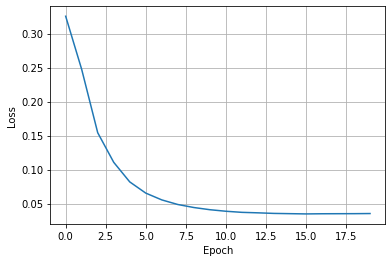

In [45]:
#Current
cw = np.zeros([v, h], np.float32)
cbr = np.zeros([v], np.float32)
cba = np.zeros([h], np.float32)
#Previous
pw = np.zeros([v, h], np.float32)
pbr = np.zeros([v], np.float32)
pba = np.zeros([h], np.float32)
sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())
#Train RBM with 20 epochs and batchsize=50
epochs = 20
batchsize = 50
losses =list()
for i in range(epochs):
    for j, k in zip( range(0, len(X_train), batchsize), range(batchsize, len(X_train), batchsize)):
        batch = X_train[j:k]
        cw = sess.run(update_w, feed_dict={x: batch, W: pw, br: pbr, ba: pba})
        cbr = sess.run(update_br, feed_dict={x: batch, W: pw, br: pbr, ba: pba})
        cnb = sess.run(update_ba, feed_dict={x: batch, W: pw, br: pbr, ba: pba})
        pw = cw
        pbr = cbr
        pba = cnb
    losses.append(sess.run(loss, feed_dict={x: X_train, W: cw, br: cbr, ba: cnb}))
plt.plot(losses)
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


#G)

In [49]:
user = [X_train[75]]
r_0 = tf.nn.sigmoid(tf.matmul(x, W) + ba)
r_1 = tf.nn.sigmoid(tf.matmul(r_0, tf.transpose(W)) + br)
feed = sess.run(r_0, feed_dict={ x: user, W: pw, ba: pba})
r = sess.run(r_1, feed_dict={ r_0: feed, W: pw, br: pbr})
user75 = movies.copy()
user75["recommendation"] = r[0]
user75.sort_values(["recommendation"], ascending=False).head(15)

,movieId,title,genres,recommendation
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,0.512960
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War,0.478854
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,0.394847
1939,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.376874
97,110,Braveheart (1995),Action|Drama|War,0.328509
2226,2959,Fight Club (1999),Action|Crime|Drama|Thriller,0.324811
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,0.317928
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,0.304973
418,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,0.298191
461,527,Schindler's List (1993),Drama|War,0.283694
